In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential, Model
from keras.layers import Dense,LSTM,Concatenate,Layer,Lambda,Input,Multiply,SimpleRNN,GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
from os.path import join as pjoin
DATA_DIR = pjoin('..', 'data')
MAX_CSV = pjoin(DATA_DIR, 'MaxV_10.csv')
DAT_CSV = pjoin(DATA_DIR, 'Data319.csv')

dataframeMV = pandas.read_csv(MAX_CSV, header=None, engine='python')
datasetMV = dataframeMV.values
datasetMV = datasetMV.astype('float32')
maxA = datasetMV[0,:]
maxT = datasetMV[1,:]

In [3]:
def create_dataset(ns):
    dataX, dataY = [], []
    maxD = 0
    minD = 10000
    for c in ns:
        dataframe = pandas.read_csv(DAT_CSV, usecols=[int(c)], engine='python')
        dataframe.dropna(how='all',inplace=True)
        dataset = dataframe.values
        dataset = dataset.astype('float32')
        sql = len(dataset)
        if np.max(dataset) > maxD:
            maxD = np.max(dataset)
        if np.min(dataset) < minD:
            minD = np.min(dataset)
        a = dataset[:sql-1,0]
        b = dataset[1:sql,0]
        #a = np.reshape(a,(sql-1,1))
        #b = np.reshape(b,(sql-1,1))
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY), minD, maxD

def create_dataset_mscale(ns,maxDV,minD):
    dataX, dataY = [], []
    for c in ns:
        #print(c)
        dn = int(c/5)
        #print(dn)
        maxD = maxDV[dn]
        dataframe = pandas.read_csv(DAT_CSV, usecols=[int(c)], engine='python')
        dataframe.dropna(how='all',inplace=True)
        dataset = dataframe.values
        dataset = dataset.astype('float32')
        dataset = (dataset - minD)/(maxD-minD)
        sql = len(dataset)
        a = dataset[:sql-1,0]
        b = dataset[1:sql,0]
        #a = np.reshape(a,(sql-1,1))
        #b = np.reshape(b,(sql-1,1))
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [4]:
ActiveLoc = np.asarray(np.linspace(0,235,48))
#ActiveLoc = [200]
TotalLoc = np.asarray(ActiveLoc) + 1
PopLoc = np.asarray(ActiveLoc) + 3
MedLoc = np.asarray(ActiveLoc) + 4

In [5]:
lb = 5

trainActive, targetActive = create_dataset_mscale(ActiveLoc,maxA,0)

trainTotal, targetTotal = create_dataset_mscale(TotalLoc,maxT,0)

trainPop, targetPop, minPop, maxPop = create_dataset(PopLoc)
#maxPop = (np.max(targetPop))
#minPop = np.min(trainPop)
trainPop = (trainPop - minPop)/(maxPop - minPop)
targetPop = (targetPop - minPop)/(maxPop - minPop)

trainMed, targetMed, minMed, maxMed = create_dataset(MedLoc)
#maxMed = np.max(targetMed)
#minMed = np.min(trainMed)
trainMed = (trainMed - minMed)/(maxMed - minMed)
targetMed = (targetMed - minMed)/(maxMed - minMed)

In [6]:
AllInput = Input(shape=(None,4))
RecInput = Lambda(lambda AllInput:AllInput[:,:,:2],name='RecIn')(AllInput)
HidInput = Lambda(lambda AllInput:AllInput[:,:,2:],name='HIn')(AllInput)
H = LSTM(20, input_shape=(None,2),return_sequences=True)(RecInput)

D2 = Dense(20,activation='softmax')(HidInput)
Data = Concatenate()([H,D2])
out = Dense(2,activation='relu')(Data)

CoVid = Model(AllInput,out)
CoVid.summary()
CoVid.compile(loss='mean_squared_error', optimizer='adam')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
RecIn (Lambda)                  (None, None, 2)      0           input_1[0][0]                    
__________________________________________________________________________________________________
HIn (Lambda)                    (None, None, 2)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 20)     1840        RecIn[0][0]                      
____________________________________________________________________________________________

In [7]:
# Loop through each training curve from different regions
# Treat each region as a single batch... 
# Reformat into trainX (1,time_steps,features) and trainY  (time_steps,features)

for e in range(100):
    for r in range(48):
        f1 = np.reshape(trainActive[r],(1,trainActive[r].shape[0],1))
        f2 = np.reshape(trainTotal[r],(1,trainTotal[r].shape[0],1))
        f3 = np.reshape(trainPop[r],(1,trainPop[r].shape[0],1))
        f4 = np.reshape(trainMed[r],(1,trainMed[r].shape[0],1))
        trainX = np.concatenate((f1,f2,f3,f4),axis=2)

        t1 = np.reshape(targetActive[r],(1,targetActive[r].shape[0],1))
        t2 = np.reshape(targetTotal[r],(1,targetTotal[r].shape[0],1))
        trainY = np.concatenate((t1,t2),axis=2)
    
        CoVid.train_on_batch(trainX, trainY)

In [8]:
AllInputI = Input(batch_shape=(1,None,4))
RecInputI = Lambda(lambda AllInput:AllInput[:,:,:2],name='RecIn')(AllInputI)
HidInputI = Lambda(lambda AllInput:AllInput[:,0,2:],name='HIn')(AllInputI)
HI = LSTM(20, input_shape=(None,2),return_sequences=False,stateful=True)(RecInputI)

D2I = Dense(20,activation='softmax')(HidInputI)
DataI = Concatenate()([HI,D2I])
outI = Dense(2,activation='relu')(DataI)

CoVidI = Model(AllInputI,outI)
CoVidI.summary()

WT = CoVid.get_weights()
CoVidI.set_weights(WT)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (1, None, 4)         0                                            
__________________________________________________________________________________________________
RecIn (Lambda)                  (1, None, 2)         0           input_2[0][0]                    
__________________________________________________________________________________________________
HIn (Lambda)                    (1, 2)               0           input_2[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (1, 20)              1840        RecIn[0][0]                      
____________________________________________________________________________________________

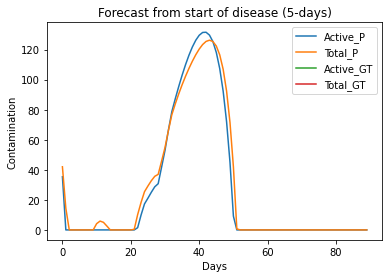

In [9]:
r = 255
maxLoc = int(r/5)
minAT = 0
minTT = 0

testActive, targetActiveT = create_dataset_mscale([r],maxA,minAT)
testTotal, targetTotalT = create_dataset_mscale([r+1],maxT,minTT)
testPop, targetPopT, nv1, nv2 = create_dataset([r+3])
testMed, targetMedT, nv3, nv4 = create_dataset([r+4])

testPop = (testPop - minPop)/(maxPop - minPop)
targetPopT = (targetPopT - minPop)/(maxPop - minPop)
testMed = (testMed - minMed)/(maxMed - minMed)
targetMedT = (targetMedT - minMed)/(maxMed - minMed)

gtl = testActive[0].shape[0]

f1 = np.reshape(testActive[0],(1,testActive[0].shape[0],1))
f2 = np.reshape(testTotal[0],(1,testTotal[0].shape[0],1))
f3 = np.reshape(testPop[0],(1,testPop[0].shape[0],1))
f4 = np.reshape(testMed[0],(1,testMed[0].shape[0],1))
testX = np.concatenate((f1,f2,f3,f4),axis=2)

t1 = np.reshape(targetActiveT[0],(1,targetActiveT[0].shape[0],1))
t2 = np.reshape(targetTotalT[0],(1,targetTotalT[0].shape[0],1))
testY = np.concatenate((t1,t2),axis=2)

fcl = 90

totalPredictT = np.zeros((1,fcl))
activePredictT = np.zeros((1,fcl))


for tp in range(fcl):
    if tp < gtl:
        initX = testX[0,tp,:]
        initX = np.reshape(initX,(1,1,4))
        singlePredict = CoVidI.predict(initX)
    else:
        ci = np.reshape(initX[0,0,2:],(1,2))
        initX = np.concatenate((singlePredict,ci),axis=1)
        initX = np.reshape(initX,(1,1,4))
        singlePredict = CoVidI.predict(initX)
            
    totalPredictT[0,tp] = np.float32(singlePredict[0][1])
    activePredictT[0,tp] = np.float32(singlePredict[0][0])



plt.plot(activePredictT[0,:]*maxA[maxLoc]*28300000)
plt.plot(totalPredictT[0,:]*maxT[maxLoc]*28300000)
plt.plot(testY[:,0]*maxA[maxLoc]*28300000)
plt.plot(testY[:,1]*maxT[maxLoc]*28300000)
plt.xlabel('Days')
plt.ylabel('Contamination')
plt.title('Forecast from start of disease (5-days)')
plt.legend(['Active_P','Total_P','Active_GT','Total_GT'])
plt.show()